<a href="https://colab.research.google.com/github/masonnystrom/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [629]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [630]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [631]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [0]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
# from pandas_profiling import ProfileReport
# profile = ProfileReport(train, minimal=True).to_notebook_iframe()

# profile

In [0]:
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


In [634]:
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [635]:
train.head()


id  amount_tsh  ... waterpoint_type_group    status_group
43360  72938         0.0  ...    communal standpipe      functional
7263   65358       500.0  ...    communal standpipe      functional
2486     469        25.0  ...             hand pump      functional
313     1298         0.0  ...                 other  non functional
52726  27001         0.0  ...    communal standpipe      functional

[5 rows x 41 columns]

In [636]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=.1)

In [637]:
train[['longitude', 'latitude']].describe()

longitude      latitude
count  47520.000000  4.752000e+04
mean      34.082431 -5.705946e+00
std        6.552053  2.941332e+00
min        0.000000 -1.164944e+01
25%       33.092142 -8.528215e+00
50%       34.910740 -5.021436e+00
75%       37.170578 -3.327185e+00
max       40.344301 -2.000000e-08

In [0]:
import numpy as np


In [0]:
# wrangle function
def wrangle(X):

  """Wrange train, validate, and tes sets of data in the same way"""

  # Prevent SettingWIthCopyWarning
  X = X.copy()

  # fix the problem with longitude and latitude and treat the near zeros
  # as zero values 

  X['latitude'] = X['latitude'].replace(-2e08, 0)

  # treat the columns with zeros that shouldn't be zero as null values
  # repalce the zeros with null so that we can impute the missing values
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  # quantity and quantity_group are duplicates
  X = X.drop(columns ='quantity_group')

  # return wrangled datafarme
  return X

In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [641]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=.1)

In [642]:
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [0]:
# Get a list of the top 10 waterpoints
top_wpt = train['wpt_name'].value_counts()[:10].index
 
# At locations where the installer is not in the top 15,
# replace the neighborhood with 'OTHER'
train.loc[~train['wpt_name'].isin(top_wpt), 'wpt_name'] = 'OTHER'
val.loc[~val['wpt_name'].isin(top_wpt), 'wpt_name'] = 'OTHER'
test.loc[~test['wpt_name'].isin(top_wpt), 'wpt_name'] = 'OTHER'

In [0]:
# Get a list of the top 15 funders
top_funders = train['funder'].value_counts()[:15].index
 
# At locations where the installer is not in the top 15,
# replace the neighborhood with 'OTHER'
train.loc[~train['funder'].isin(top_funders), 'funder'] = 'OTHER'
val.loc[~val['funder'].isin(top_funders), 'funder'] = 'OTHER'
test.loc[~test['funder'].isin(top_funders), 'funder'] = 'OTHER'

In [0]:
# Get a list of the top 15 installers
top_installer = train['installer'].value_counts()[:15].index
 
# At locations where the installer is not in the top 15,
# replace the neighborhood with 'OTHER'
train.loc[~train['installer'].isin(top_installer), 'installer'] = 'OTHER'
val.loc[~val['installer'].isin(top_installer), 'installer'] = 'OTHER'
test.loc[~test['installer'].isin(top_installer), 'installer'] = 'OTHER'

In [0]:
 # Get a list of the top 5 subvillage over 200 people
top5_subvillage = train['subvillage'].value_counts()[:5].index
 
# At locations where the subvillage is not in the top 15,
# replace the neighborhood with 'OTHER'
train.loc[~train['subvillage'].isin(top5_subvillage), 'subvillage'] = 'OTHER'
val.loc[~val['subvillage'].isin(top5_subvillage), 'subvillage'] = 'OTHER'
test.loc[~test['subvillage'].isin(top5_subvillage), 'subvillage'] = 'OTHER'

In [0]:
 # Get a list of the top 5 subvillage over 200 people
top15_ward = train['ward'].value_counts()[:15].index
 
# At locations where the ward is not in the top 15,
# replace the neighborhood with 'OTHER'
train.loc[~train['ward'].isin(top15_ward), 'ward'] = 'OTHER'
val.loc[~val['ward'].isin(top15_ward), 'ward'] = 'OTHER'
test.loc[~test['ward'].isin(top15_ward), 'ward'] = 'OTHER'

In [0]:
top15_lga = train['lga'].value_counts()[:15].index
 
# At locations where the lga is not in the top 15,
# replace the neighborhood with 'OTHER'
train.loc[~train['lga'].isin(top15_lga), 'lga'] = 'OTHER'
val.loc[~val['lga'].isin(top15_lga), 'lga'] = 'OTHER'
test.loc[~test['lga'].isin(top15_lga), 'lga'] = 'OTHER'

In [0]:
top15_num_private = train['num_private'].value_counts()[:15].index
 
# At locations where the num_private is not in the top 15,
# replace the neighborhood with 'OTHER'
train.loc[~train['num_private'].isin(top15_num_private), 'num_private'] = 'OTHER'
val.loc[~val['num_private'].isin(top15_num_private), 'num_private'] = 'OTHER'
test.loc[~test['num_private'].isin(top15_num_private), 'num_private'] = 'OTHER'

In [0]:
top10_scheme_name = train['scheme_name'].value_counts()[:15].index
 
# At locations where the num_private is not in the top 15,
# replace the neighborhood with 'OTHER'
train.loc[~train['scheme_name'].isin(top10_scheme_name), 'scheme_name'] = 'OTHER'
val.loc[~val['scheme_name'].isin(top10_scheme_name), 'scheme_name'] = 'OTHER'
test.loc[~test['scheme_name'].isin(top10_scheme_name), 'scheme_name'] = 'OTHER'

In [0]:
 # At locations where the installer is not in the top 15,
# replace the neighborhood with 'OTHER'
train.loc[~train['subvillage'].isin(top5_subvillage), 'subvillage'] = 'OTHER'
val.loc[~val['subvillage'].isin(top5_subvillage), 'subvillage'] = 'OTHER'
test.loc[~test['subvillage'].isin(top5_subvillage), 'subvillage'] = 'OTHER'


In [652]:
# select features 

#target
target = 'status_group'


# get a dataframe with all trian columns except target and ID
train_features = train.drop(columns=[target, 'id'])

#numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# features with cardinality of no-numeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# get a list of all categorical feature with high cardinality
categorical_features = cardinality[cardinality <=50].index.tolist()

# combine the lists

features = numeric_features + categorical_features
print(features)
print(target)



['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'funder', 'installer', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
status_group


In [0]:
# arrange the X features matrix and y vectors
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]


In [654]:
X_train.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'construction_year', 'funder',
       'installer', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler
model = LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=1)

In [0]:
# make the pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=1)
)

In [658]:
# fit on training
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['funder', 'installer', 'wpt_name',
                                     'num_private', 'basin', 'subvillage',
                                     'region', 'lga', 'ward', 'public_meeting',
                                     'recorded_by', 'scheme_management',
                                     'scheme_name', 'permit', 'extraction_type',
                                     'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type'...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                  

In [659]:
# first Val accuracy
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.7411616161616161


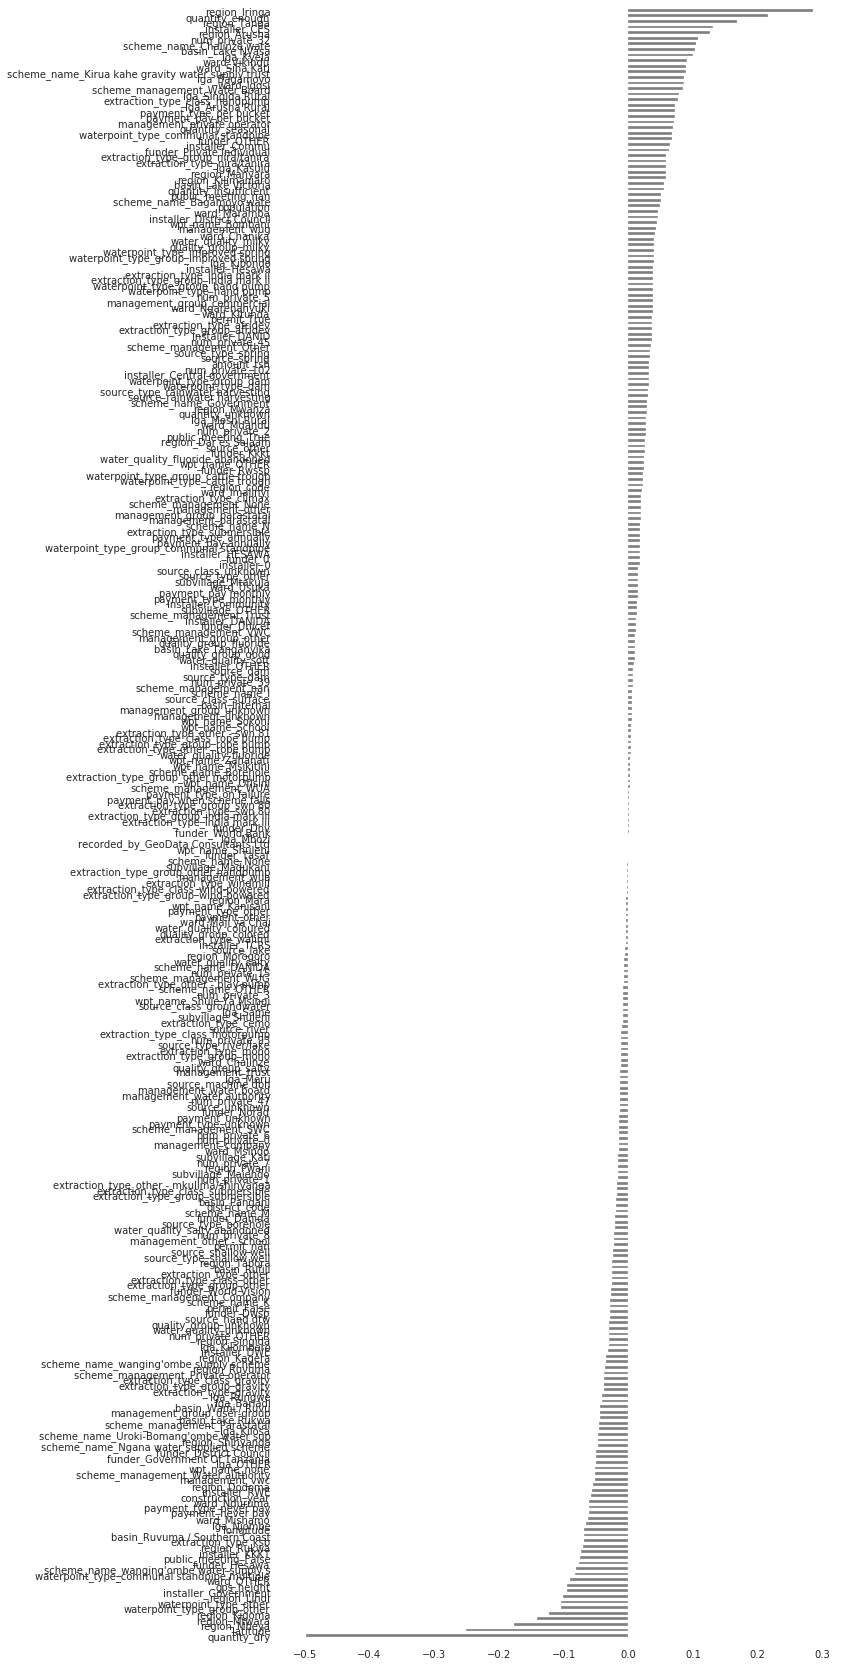

In [660]:
# practice taking out steps so we can reference them 
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']

encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)

plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [0]:
# importing DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42, min_samples_leaf=20)
)

In [662]:
# fit the training
pipeline.fit(X_train, y_train)
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Val Accuracy:', pipeline.score(X_val, y_val) )

Train Accuracy: 0.8101851851851852
Val Accuracy: 0.7721380471380471


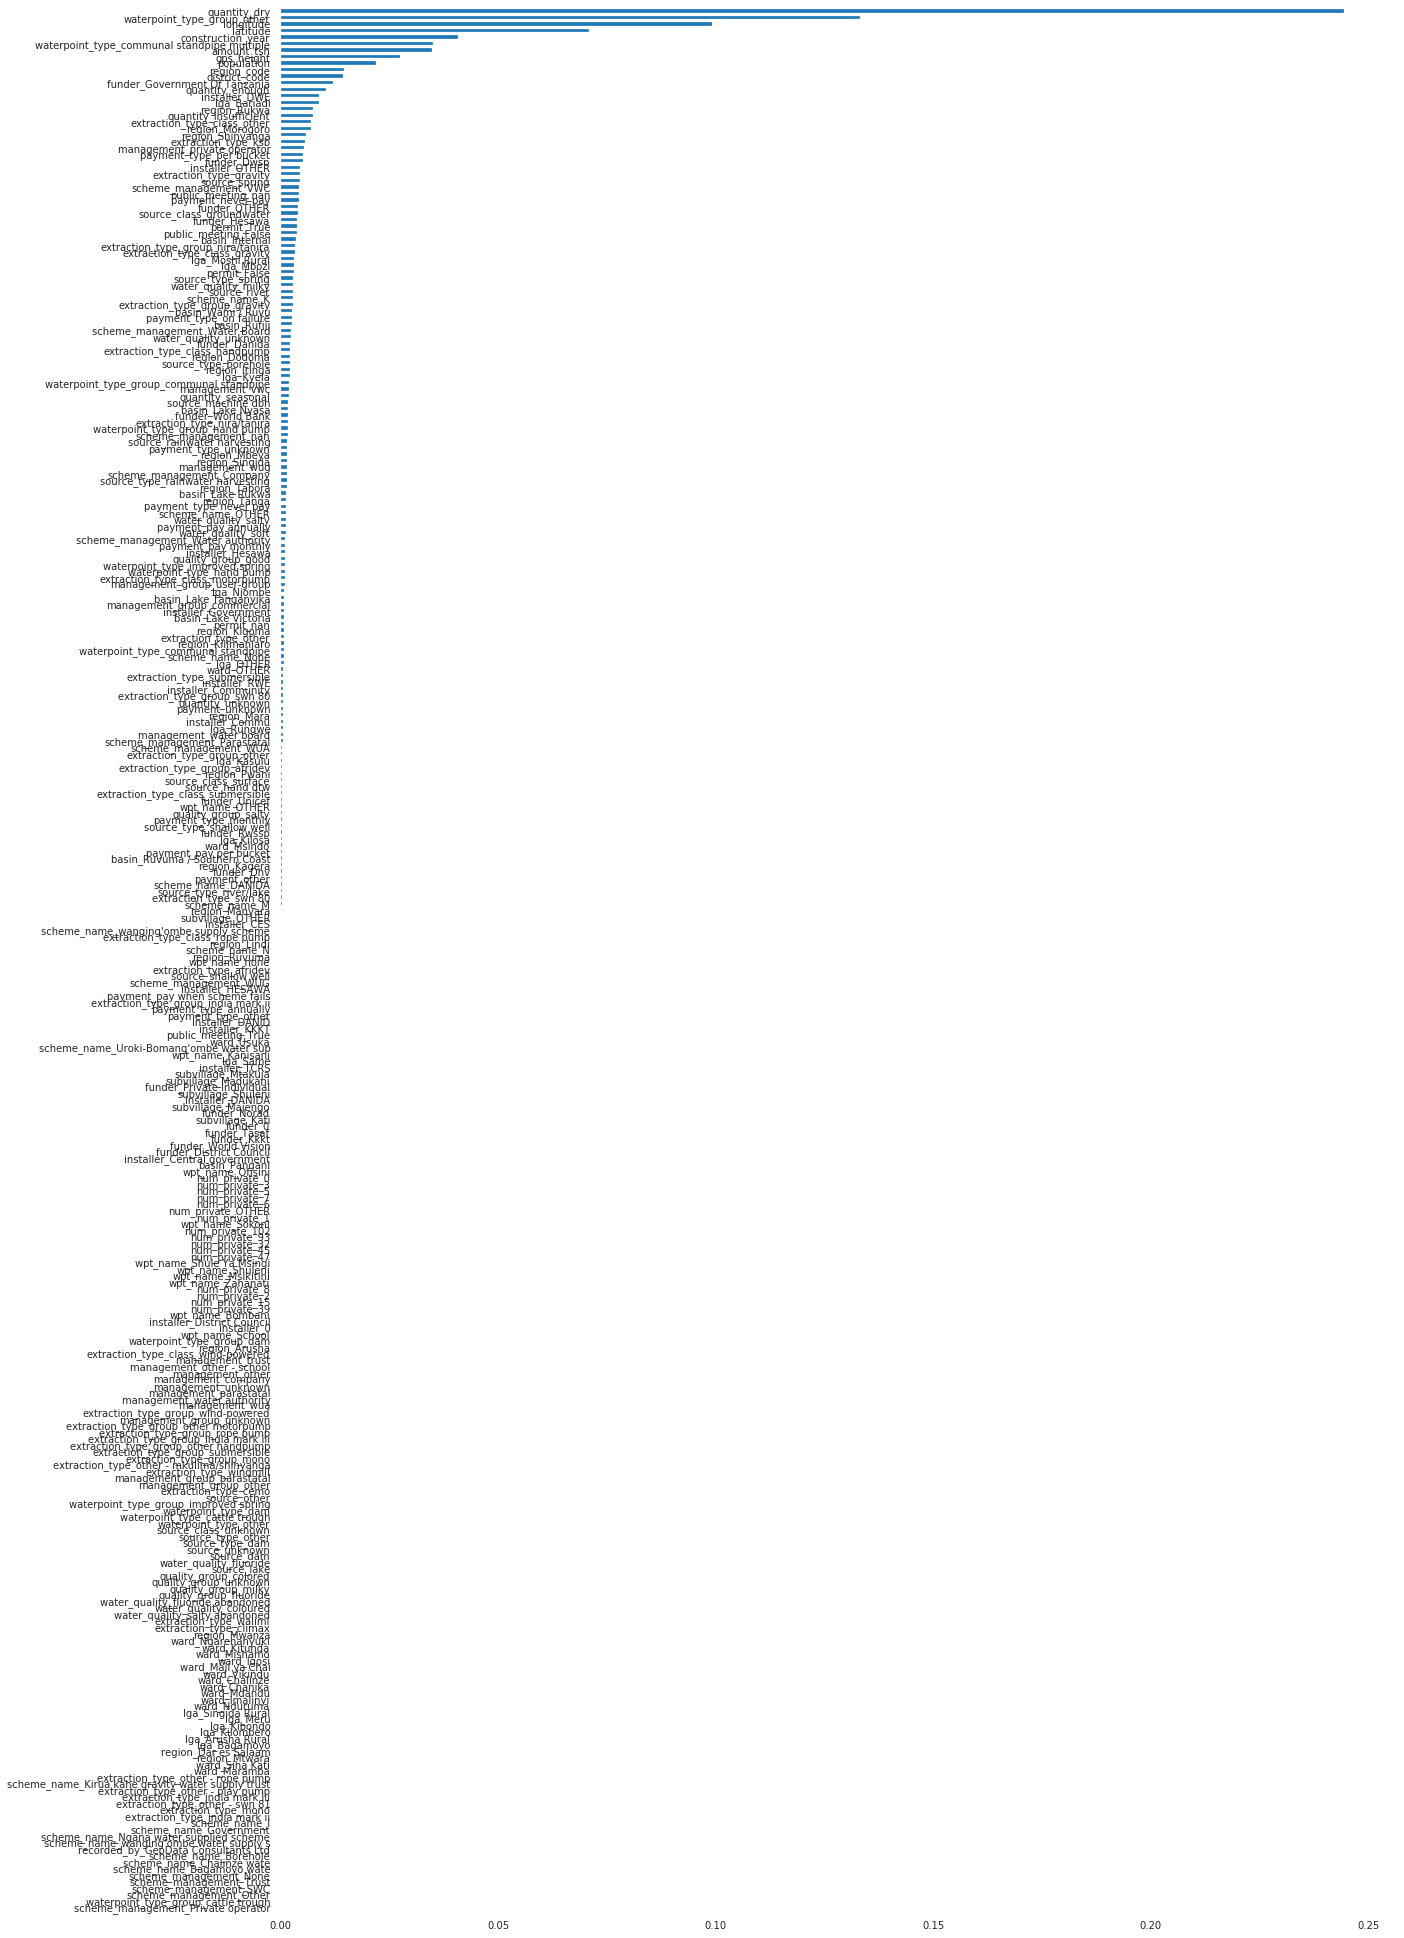

In [663]:
# sorting importances
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
imputer = pipeline.named_steps['simpleimputer']

encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)

plt.figure(figsize=(20,35))
importances.sort_values().plot.barh();

In [0]:
train_location = X_train[['longitude', 'latitude']].copy()
val_location = X_val[['longitude', 'latitude']].copy()

In [665]:
# example from class of long and lat

longlat = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42, min_samples_leaf=20)
)

longlat.fit(train_location, y_train)
print('Train Accuracy:', longlat.score(train_location, y_train))
print('Val Accuracy:', longlat.score(val_location, y_val))

Train Accuracy: 0.7149831649831649
Val Accuracy: 0.6531144781144781


In [0]:
X_train_group1 = X_train[['waterpoint_type','extraction_type_class', 
                        'waterpoint_type_group','population',
                        'public_meeting', 'gps_height','construction_year'
                        ]].copy()
X_val_group1 = X_val[['waterpoint_type','extraction_type_class', 
                        'waterpoint_type_group','population',
                        'public_meeting', 'gps_height','construction_year'
                        ]].copy()

In [0]:
from sklearn.tree import DecisionTreeClassifier


In [668]:
group1 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42, min_samples_leaf=15)
)
group1.fit(X_train_group1, y_train)
print('Train Accuracy:', group1.score(X_train_group1, y_train))
print('Val Accuracy:', group1.score(X_val_group1, y_val))

Train Accuracy: 0.716456228956229
Val Accuracy: 0.6744107744107745


In [0]:
# lets try another set with 14 features
X_train_group2 = X_train[['longitude','latitude','waterpoint_type','extraction_type_class', 
                        'waterpoint_type_group','population',
                        'public_meeting', 'gps_height','construction_year', 
                        'payment_type', 'water_quality', 'quality_group', 
                        'quantity', 'source'
                        ]].copy()
X_val_group2 = X_val[['longitude','latitude','waterpoint_type','extraction_type_class', 
                        'waterpoint_type_group','population',
                        'public_meeting', 'gps_height','construction_year',
                        'payment_type', 'water_quality', 'quality_group',
                        'quantity', 'source'
                        ]].copy()

In [670]:
group2 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='constant'),
    DecisionTreeClassifier(random_state=42, max_depth=15)
)
group2.fit(X_train_group2, y_train)
print('Train Accuracy:', group2.score(X_train_group2, y_train))
print('Val Accuracy:', group2.score(X_val_group2, y_val))

Train Accuracy: 0.8440656565656566
Val Accuracy: 0.7707912457912458


In [671]:
X_train.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code',
       'district_code', 'population', 'construction_year', 'funder',
       'installer', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [0]:
# source and source_type are the same except they have diff names for borhole/machine dbh

In [0]:
X_train_group3 = X_train[['amount_tsh', 'gps_height','region_code', 'district_code', 'population', 'construction_year',
                          'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region','public_meeting', 
                          'scheme_management', 'permit', 'extraction_type_class', 'num_private','management', 
                          'payment', 'payment_type','water_quality', 'quality_group',
                          'quantity', 'source_type','source_class', 'waterpoint_type', 'waterpoint_type_group', 
                          'lga', 'ward', 'latitude', 'longitude', 'scheme_name'
                        ]].copy()
X_val_group3 = X_val[['amount_tsh', 'gps_height','region_code', 'district_code', 'population', 'construction_year',
                          'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region','public_meeting', 
                          'scheme_management', 'permit', 'extraction_type_class', 'num_private','management', 
                          'payment', 'payment_type','water_quality', 'quality_group',
                          'quantity', 'source_type','source_class', 'waterpoint_type', 'waterpoint_type_group', 
                          'lga', 'ward', 'latitude', 'longitude', 'scheme_name'
                        ]].copy()

In [698]:
group3 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42, min_samples_leaf=15)

 )
group3.fit(X_train_group3, y_train)

print('Train Accuracy:', group3.score(X_train_group3, y_train))
print('Val Accuracy:', group3.score(X_val_group3, y_val))

Train Accuracy: 0.8204124579124579
Val Accuracy: 0.7773569023569024
